In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [2]:
data = pd.read_csv("C:/Users/rohit/Downloads/Google_train_data.csv")
data.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [4]:
training_set = data.iloc[:,1:2].values

print(training_set)
print(training_set.shape)

[[325.25]
 [331.27]
 [329.83]
 ...
 [793.7 ]
 [783.33]
 [782.75]]
(1258, 1)


In [5]:
data["Close"]=pd.to_numeric(data.Close,errors='coerce') #to change 'close' datatype
data= data.dropna() #to drop any missing values
trainData= data.iloc[:,4:5].values #to use only 'close' column to train the data

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1149 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1149 non-null   object 
 1   Open    1149 non-null   float64
 2   High    1149 non-null   float64
 3   Low     1149 non-null   float64
 4   Close   1149 non-null   float64
 5   Volume  1149 non-null   object 
dtypes: float64(4), object(2)
memory usage: 62.8+ KB


In [7]:
sc = MinMaxScaler(feature_range=(0,1)) #rescale values between 0 and 1 for better performance
trainData = sc.fit_transform(trainData) #transform the data

trainData.shape

(1149, 1)

In [8]:
X_train = []
y_train = []
for i in range(60,1149): #input for lstm is 3d so it will have timestep, sequence length and batch size
    #timestep= 60, seqlen=1149
    X_train.append(trainData[i-60:i,0])
    y_train.append(trainData[i,0])
X_train = np.array(X_train)
y_train = np.array(y_train)


In [9]:
X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1], 1))
#adding the batchsize axis
X_train.shape

(1089, 60, 1)

In [10]:
#model with 4lstm layers, all followed by a dropout layer, adam is the optimizer and meansqerror is the loss function

model = Sequential()

model.add(LSTM(units = 100, return_sequences= True, input_shape= (X_train.shape[1], 1)))
model.add(Dropout(0.1))

model.add(LSTM(units = 100, return_sequences= True))
model.add(Dropout(0.1))

model.add(LSTM(units = 100, return_sequences= True))
model.add(Dropout(0.1))

model.add(LSTM(units = 100))
model.add(Dropout(0.1))

model.add(Dense(units=1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [11]:
hist= model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=2) #training of the model

Epoch 1/10
35/35 - 42s - loss: 0.0422 - 42s/epoch - 1s/step
Epoch 2/10
35/35 - 14s - loss: 0.0101 - 14s/epoch - 405ms/step
Epoch 3/10
35/35 - 233s - loss: 0.0096 - 233s/epoch - 7s/step
Epoch 4/10
35/35 - 9s - loss: 0.0094 - 9s/epoch - 268ms/step
Epoch 5/10
35/35 - 14s - loss: 0.0075 - 14s/epoch - 391ms/step
Epoch 6/10
35/35 - 15s - loss: 0.0070 - 15s/epoch - 419ms/step
Epoch 7/10
35/35 - 14s - loss: 0.0065 - 14s/epoch - 404ms/step
Epoch 8/10
35/35 - 276s - loss: 0.0058 - 276s/epoch - 8s/step
Epoch 9/10
35/35 - 10s - loss: 0.0052 - 10s/epoch - 300ms/step
Epoch 10/10
35/35 - 13s - loss: 0.0055 - 13s/epoch - 380ms/step


In [12]:
model.save('model.h5')

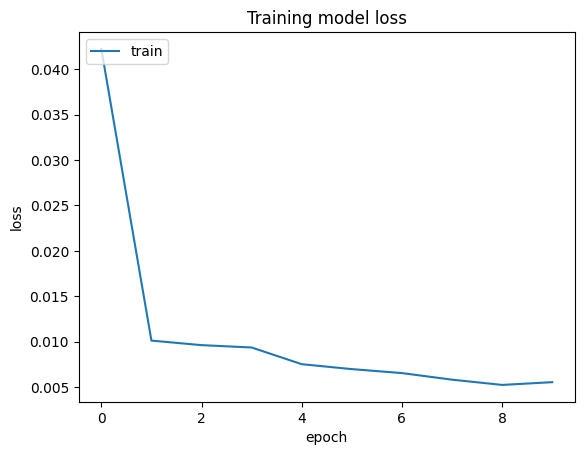

In [13]:
#plotting the loss incurred during each epoch iteration
plt.plot(hist.history['loss'])
plt.title('Training model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [14]:
import pandas
testData = pd.read_csv("C:/Users/rohit/Downloads/Google_test_data.csv")
testData["Close"]=pd.to_numeric(testData.Close,errors='coerce') #to change 'close' Datatype
testData= testData.dropna() #to drop any missing values
testData= testData.iloc[:,4:5] #to use only 'close' column to train the testData

y_test = testData.iloc[60:,0:].values #to select rows and columns on integer based indexing

#input array for the model

inputClosing = testData.iloc[:,0:].values
inputClosing_scaled = sc.transform(inputClosing)
inputClosing_scaled.shape

X_test = []
length = len(testData)
timestep = 60
for i in range(timestep, length):
    X_test.append(inputClosing_scaled[i-timestep:i,0])
X_test = np.array(X_test) #converting x_test data into numpy array
x_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
X_test.shape

(192, 60)

In [15]:
y_pred = model.predict(X_test) #predicting model output
y_pred

6/6 [==============================] - 7s 114ms/step


array([[1.2120429],
       [1.2090043],
       [1.2102717],
       [1.2165588],
       [1.2262334],
       [1.2354145],
       [1.2410377],
       [1.2421683],
       [1.240554 ],
       [1.2378906],
       [1.232727 ],
       [1.2245966],
       [1.2146511],
       [1.2034391],
       [1.1933516],
       [1.1859373],
       [1.1846412],
       [1.1912073],
       [1.205732 ],
       [1.2273629],
       [1.2501607],
       [1.2701498],
       [1.2827069],
       [1.2858518],
       [1.2807393],
       [1.2705655],
       [1.2583796],
       [1.2452557],
       [1.2302891],
       [1.2140397],
       [1.1972164],
       [1.1799799],
       [1.1610065],
       [1.1398925],
       [1.1214216],
       [1.1097649],
       [1.1066394],
       [1.1117284],
       [1.1240277],
       [1.1397145],
       [1.1587225],
       [1.1805168],
       [1.2044295],
       [1.2290076],
       [1.252169 ],
       [1.2711456],
       [1.2832512],
       [1.2895287],
       [1.2918786],
       [1.2925944],


In [16]:
predicted_price = sc.inverse_transform(y_pred)

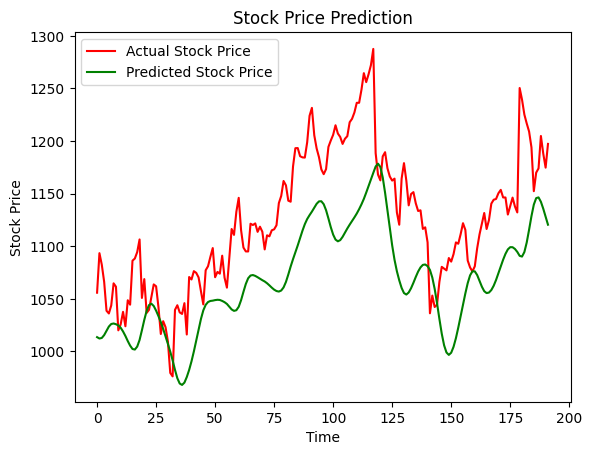

In [17]:
plt.plot(y_test, color= 'red', label= 'Actual Stock Price')
plt.plot(predicted_price, color= 'green', label= 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()